# Detector Optimization

In this program, I'll try to optimize a simple trackingsystem using Bayesian optimization with Gaussian processes. The same method can be used for more complex systems optimization. For an example, the ATLAS tracking system:

<img src="Images/tracks.png" width="700" />
https://twiki.cern.ch/twiki/bin/view/AtlasPublic/EventDisplayRun2Collisions

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils

# Geometry generation

Our simple tracking system consists of 4 layers of straw tubes, which detects particles fly through them. Each layer has 200 tubes. The system is parametrized by six adjustable parameters: $y_{1}$, $y_{2}$, $y_{3}$, $z_{1}$, $z_{2}$, $z_{3}$. These parameters describe shifts between the layers as it is show in the figure: 

<img src="Images/system.png" alt="Drawing" style="width: 700px;">

In this notebook we suppose that the radius $R$ of tubes is 1 cm and the distance between tubes in one layer (pitch) is 4 cm. We take these values as constants and will not change them.  Also z-value must be more than 2, otherwise these tubes will intersect. It's wrong.

For an example, lets select values for the layers shifts.

In [2]:
# CONSTANT PARAMETERS
R = 1. # cm
pitch = 4.0 #cm 

# ADJUSTABLE PARAMETERS
y1 = 0.0
y2 = 0.0
y3 = 0.0
z1 = 2.0
z2 = 4.0
z3 = 6.0

Using these parameter values we generate $Z$ and $Y$ coordinates of tubes in the tracking system.

In [3]:
tr = utils.Tracker(R, pitch, y1, y2, y3, z1, z2, z3)
Z, Y = tr.create_geometry()

Now display several tubes of the generated geometry.

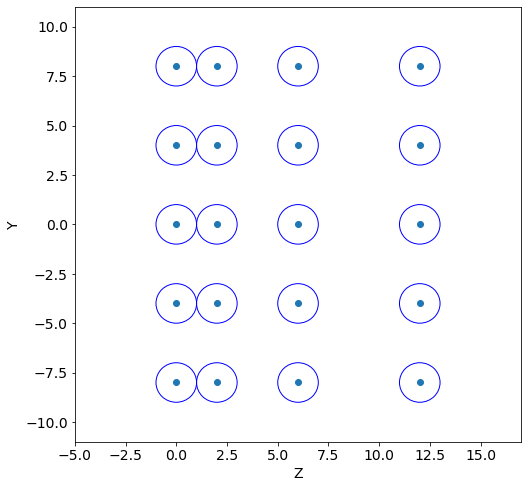

In [4]:
utils.geometry_display(Z, Y, R, y_min=-10, y_max=10)

# Tracks generation

Lets generate several tracks of particles fly in the tracking system. We consider straight tracks with equation: 

$$
y = kz + b
$$

where $z, y$ are coordinates of the track, $k$ is slope of the track and $b$ is the y intercept.

Track parameters are generated from the following distributions:

$$
b \in U(b_{min}, b_{max})\\
k = tan(\alpha), \alpha \in N(\mu_{\alpha}, \sigma_{\alpha})
$$

where $U$ is uniform distribution and $N$ is normal distribution.

In [5]:
N_tracks = 1000
t = utils.Tracks(b_min=-100, b_max=100, alpha_mean=0, alpha_std=0.2)
tracks = t.generate(N_tracks)

Display the tubes geometry with the generated tracks.

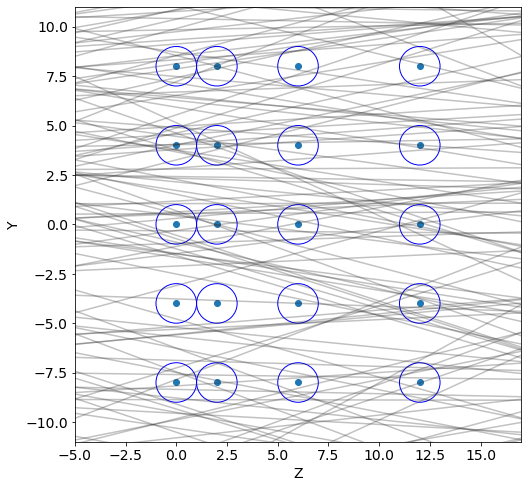

In [6]:
utils.geometry_display(Z, Y, R, y_min=-10, y_max=10)
utils.tracks_display(tracks, Z)

# Target metric

For a given geaometry of the tracking system we will calculate the ratio of tracks with at least 2 hits to the total number of tracks:

$$Score = \frac{N\_tracks_{n\_hits \ge 2}}{N\_tracks}$$

The higher score, the better.

In [7]:
score = utils.get_score(Z, Y, tracks, R)
print(score)

0.648


# Optimization

In this programming assignment you need to find parameters of geometry of the tracking system that provides the highest **score** value. However, we propose to solve a minimization problem. So you need to minimize **1-score** value. This is an objective function of the optimization


Lets define ranges of the adjustable parameters of the system.

In [8]:
# We can definetly change these ranges

y1_min, y1_max = [0, 4]
y2_min, y2_max = [0, 4]
y3_min, y3_max = [0, 4]
z1_min, z1_max = [2, 10]
z2_min, z2_max = [2, 10]
z3_min, z3_max = [2, 10]

And generate tracks used during the optimization.

In [9]:
t = utils.Tracks(-100, 100, 0, 0.2)
tracks = t.generate(1000)

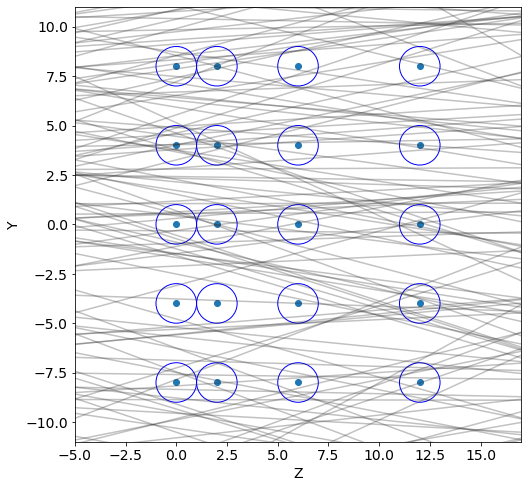

In [10]:
utils.geometry_display(Z, Y, R, y_min=-10, y_max=10)
utils.tracks_display(tracks, Z)

Define the objective function of the optimization

In [11]:
def objective(x):
    
    R, pitch, y1, y2, y3, z1, z2, z3 = x
    Z, Y = utils.Tracker(R, pitch, y1, y2, y3, z1, z2, z3).create_geometry()
    val = utils.get_score(Z, Y, tracks, R)
    
    return 1. - val # the smaller, the better.

## Grid search

Firstly, lets try to solve the optimization problem using grid search.

TASK: find optimal parameters of the tracking system using grid search.

In [12]:
%%time

# We can definetly change these ranges

y1_min, y1_max = [1, 3]
y2_min, y2_max = [2, 3]
y3_min, y3_max = [1, 3]
z1_min, z1_max = [1, 3]
z2_min, z2_max = [9, 11]
z3_min, z3_max = [1, 3]

# Number of unique values for each of the adjustable parameters.
n_points = 3

# Define grid of the parameters
y1_grid = np.linspace(y1_min, y2_max, n_points)
y2_grid = np.linspace(y2_min, y2_max, n_points)
y3_grid = np.linspace(y3_min, y3_max, n_points)
z1_grid = np.linspace(z1_min, z1_max, n_points)
z2_grid = np.linspace(z2_min, z2_max, n_points)
z3_grid = np.linspace(z3_min, z3_max, n_points)

# Define list to store the optimization results
min_objective_values = []
params_for_min_objective_values = []

is_first = True

# Loop on the grid
for y1 in y1_grid:
    for y2 in y2_grid:
        for y3 in y3_grid:
            for z1 in z1_grid:
                for z2 in z2_grid:
                    for z3 in z3_grid:

                        # Calculate the objective function value for a grid node
                        x = [R, pitch, y1, y2, y3, z1, z2, z3]
                        val = objective(x)

                        if is_first:
                            min_objective_values.append(val)
                            params_for_min_objective_values.append(tuple(x))
                            is_first = False
                        elif val < min_objective_values[-1]:
                            min_objective_values.append(val)
                            params_for_min_objective_values.append(tuple(x))
                        else:
                            min_objective_values.append(min_objective_values[-1])
                            params_for_min_objective_values.append(params_for_min_objective_values[-1])

Wall time: 15.2 s


Plot the optimization curve

Objective optimum =  0.05300000000000005


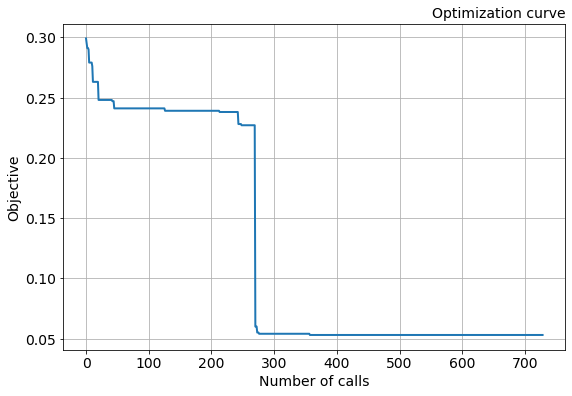

In [13]:
print("Objective optimum = ", min_objective_values[-1])
utils.plot_objective(min_objective_values)

In [14]:
(R, pitch, y1, y2, y3, z1, z2, z3) = params_for_min_objective_values[-1]
print("Optimal parameters: ")
print("y1 = ", y1)
print("y2 = ", y2)
print("y3 = ", y3)
print("z1 = ", z1)
print("z2 = ", z2)
print("z3 = ", z3)

Optimal parameters: 
y1 =  2.0
y2 =  2.5
y3 =  2.0
z1 =  1.0
z2 =  11.0
z3 =  1.0


Display the optimal tracking system geometry.

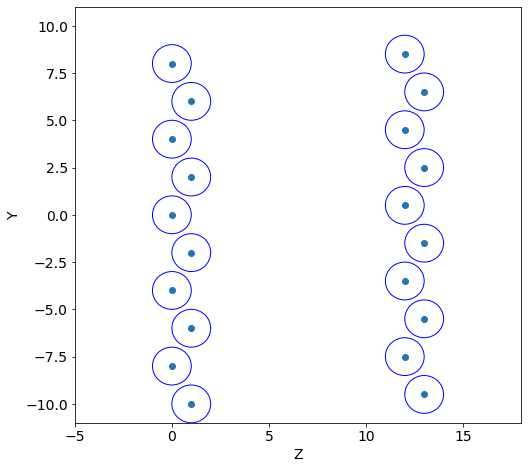

In [15]:
# Without Tracks

Z, Y = utils.Tracker(R, pitch, y1, y2, y3, z1, z2, z3).create_geometry()
utils.geometry_display(Z, Y, R, y_min=-10, y_max=10)

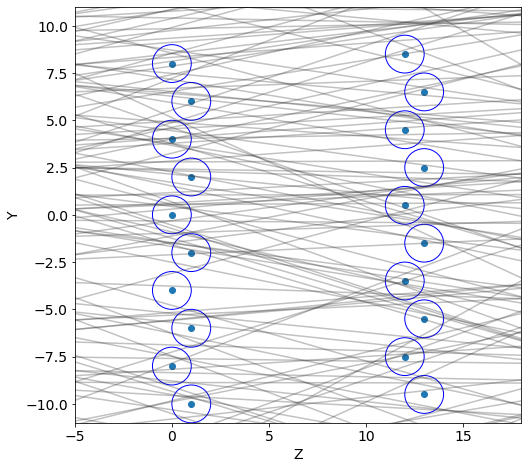

In [16]:
# With Tracks

utils.geometry_display(Z, Y, R, y_min=-10, y_max=10)
utils.tracks_display(tracks, Z)

## Random search

Now, lets modify grid search. For this we will generate random points in the parameter space instead of the grid.

TASK: find optimal parameters of the tracking system using random search.

In [17]:
%%time

# Number of random point to generate.
n_points = 400

# Define normally distributed random values on the tracking system parameters

y1_grid = np.random.RandomState(12).normal(2, 0.5, n_points)
y2_grid = np.random.RandomState(13).normal(2, 0.5, n_points)
y3_grid = np.random.RandomState(14).normal(2, 0.5, n_points)
z1_grid = np.random.RandomState(15).normal(2, 0.5, n_points)
z2_grid = np.random.RandomState(16).normal(11,0.5, n_points)
z3_grid = np.random.RandomState(17).normal(2, 0.5, n_points)


# Define list to store the optimization results
min_objective_values = []
params_for_min_objective_values = []

for i in range(n_points):
    
    y1 = y1_grid[i]
    y2 = y2_grid[i]
    y3 = y3_grid[i]
    z1 = z1_grid[i]
    z2 = z2_grid[i]
    z3 = z3_grid[i]
    
    # Calculate the objective function value for a grid node
    x = [R, pitch, y1, y2, y3, z1, z2, z3]
    val = objective(x)
    
    if i==0:
        min_objective_values.append(val)
        params_for_min_objective_values.append(tuple(x))
    elif val < min_objective_values[-1]:
        min_objective_values.append(val)
        params_for_min_objective_values.append(tuple(x))
    else:
        min_objective_values.append(min_objective_values[-1])
        params_for_min_objective_values.append(params_for_min_objective_values[-1])

Wall time: 8.26 s


Plot the optimization curve

Objective optimum =  0.07599999999999996


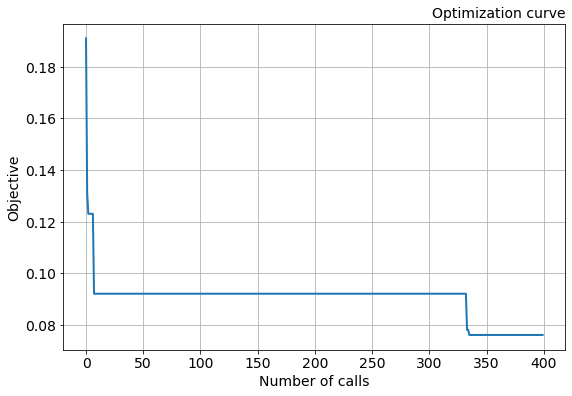

In [18]:
print("Objective optimum = ", min_objective_values[-1])
utils.plot_objective(min_objective_values)

In [19]:
(R, pitch, y1, y2, y3, z1, z2, z3) = params_for_min_objective_values[-1]
print("Optimal parameters: ")
print("y1 = ", y1)
print("y2 = ", y2)
print("y3 = ", y3)
print("z1 = ", z1)
print("z2 = ", z2)
print("z3 = ", z3)

Optimal parameters: 
y1 =  2.160533295730071
y2 =  1.3041169578529819
y3 =  1.9399400419549917
z1 =  1.0652532578893408
z2 =  10.64753678085711
z3 =  0.9280410755867388


Display the optimal tracking system geometry.

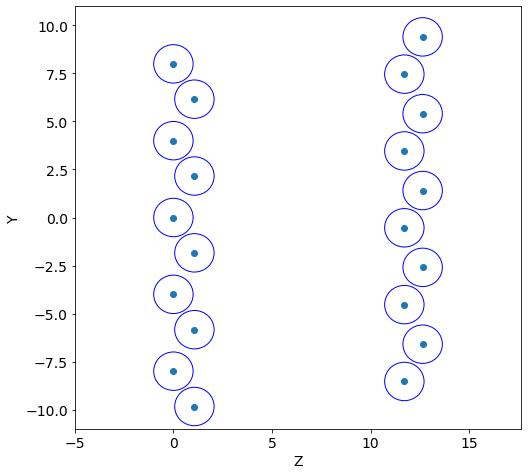

In [20]:
# Without Tracks

Z, Y = utils.Tracker(R, pitch, y1, y2, y3, z1, z2, z3).create_geometry()
utils.geometry_display(Z, Y, R, y_min=-10, y_max=10)

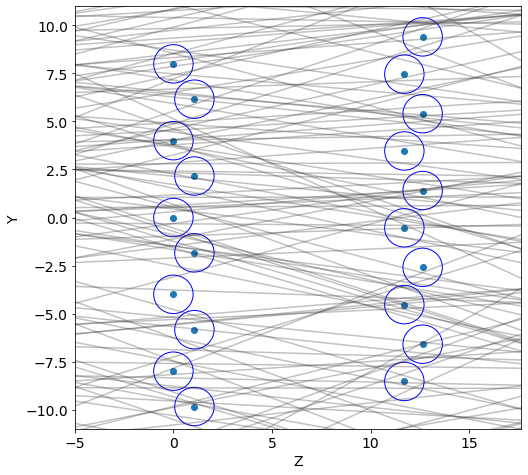

In [21]:
# With Tracks

utils.geometry_display(Z, Y, R, y_min=-10, y_max=10)
utils.tracks_display(tracks, Z)

## Bayesian optimization with Gaussian processes

At this step we will use Bayesian optimization implemented using [scikit-optimize](http://scikit-optimize.github.io/) library to find optimal tracking system geometry. During the optimization Lower Confidence Bound (LCB) acquisition function is used:

$$
LCB(x) = \mu(x) - \kappa(x) 
$$

where $\kappa$ is adjustable parameter that defines the exploration-exploitation trade-off of the optimization.

TASK: To find Optimal Parameters of the Tracking System.

In [22]:
from skopt import gp_minimize

c:\users\lenovo\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [23]:
# Theses values can be adjsuted to change range.

y1_min, y1_max = [1, 3]
y2_min, y2_max = [2, 3]
y3_min, y3_max = [1, 3]
z1_min, z1_max = [1, 3]
z2_min, z2_max = [9, 11]
z3_min, z3_max = [1, 3]

kappa= 1
dimentions = [(R, R + 10**-6), 
              (pitch, pitch + 10**-6), 
              (y1_min, y1_max), 
              (y2_min, y2_max), 
              (y3_min, y3_max),
              (z1_min, z1_max), 
              (z2_min, z2_max), 
              (z3_min, z3_max)]

res = gp_minimize(func=objective,             # the function to minimize
                  dimensions=dimentions,            # the bounds on each dimension of x
                  acq_func="LCB",                   # the acquisition function
                  n_calls=60,                      # the number of evaluations of f 
                  n_random_starts=10,               # the number of random initialization points
                  noise=0.01**2,                    # the noise level (optional)
                  random_state=123,                 # the random seed
                  kappa=kappa,                      # the adjustable parameter of LCB
                  n_jobs=3)

c:\users\lenovo\appdata\local\programs\python\python36\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\users\lenovo\appdata\local\programs\python\python36\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\users\lenovo\appdata\local\programs\python\python36\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\users\lenovo\appdata\local\programs\python\python36\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\users\lenovo\appdata\local\programs\python\python36\lib\site-packages\skopt\optimizer\opt

Plot the optimization curve

In [24]:
from skopt.plots import plot_convergence, plot_regret, plot_objective, plot_evaluations

Objective optimum =  0.05400000000000005


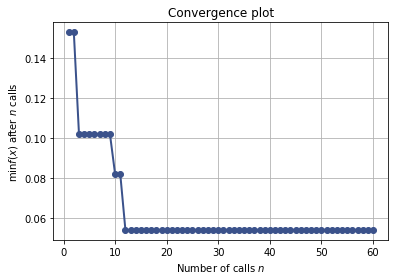

[('R', 1.0000004042696995), ('pitch', 4.0000009145501885), ('y1', 2), ('y2', 3), ('y3', 2), ('z1', 1), ('z2', 10), ('z3', 1)]


In [25]:
# Convergence Traces

print("Objective optimum = ", res.fun)
plot_convergence(res)
plt.show()
print (list(zip(["R", "pitch", "y1", "y2", "y3", "z1", "z2", "z3"], res.x)))

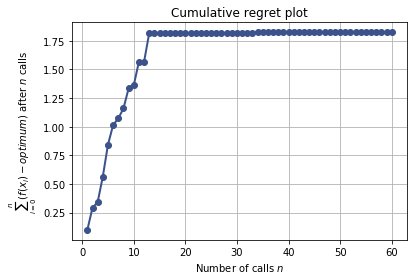

In [26]:
# Cumulative regret traces

plot_regret(res)
plt.show()

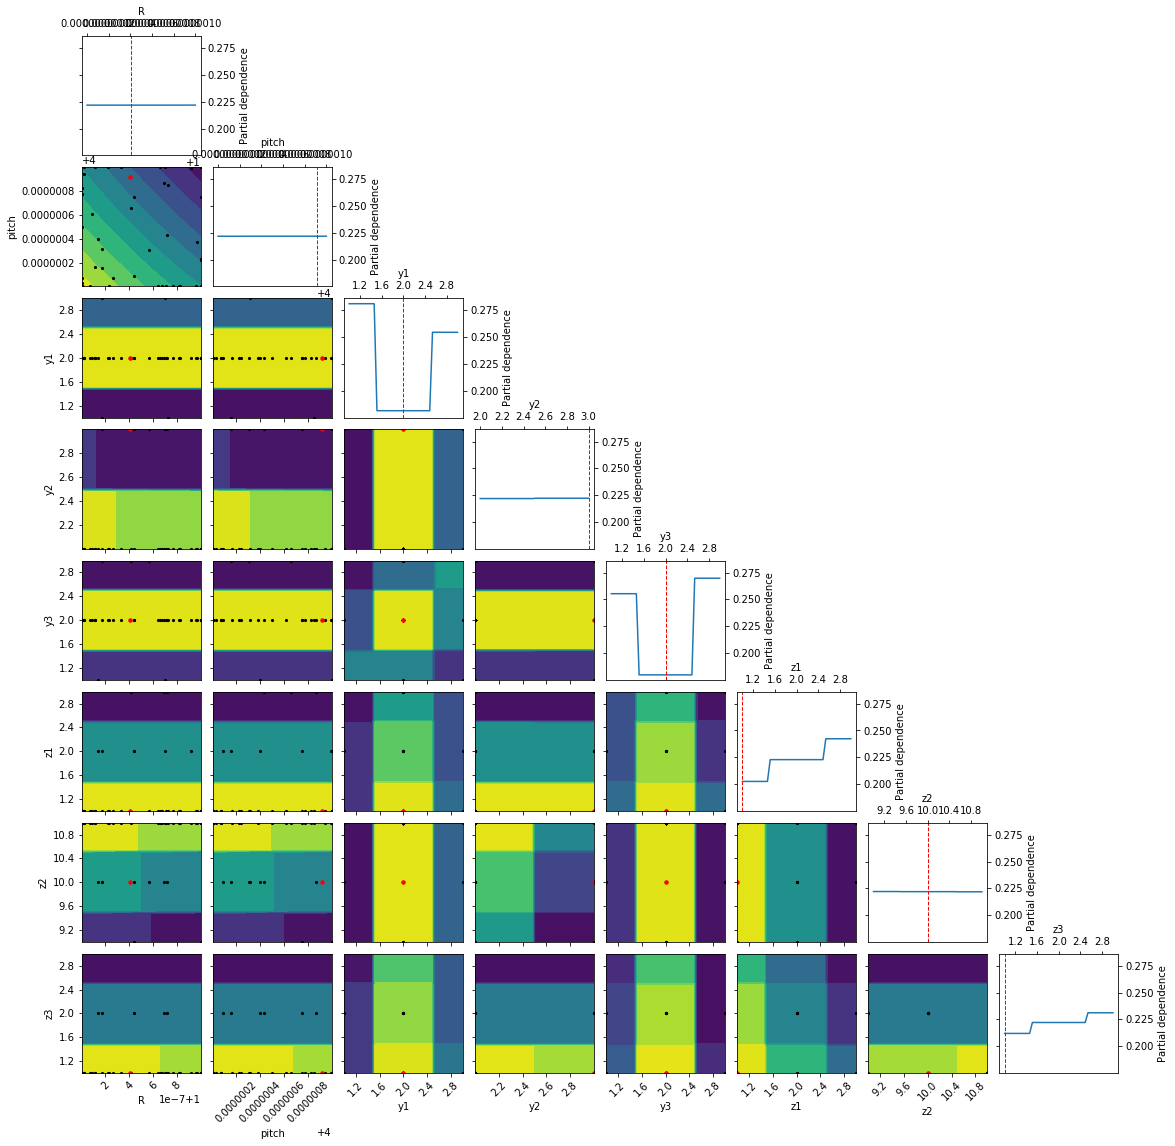

In [27]:
# Pairwise dependence plot of the objective function

plot_objective(res, dimensions=["R", "pitch", "y1", "y2", "y3", "z1", "z2", "z3"])
plt.show()

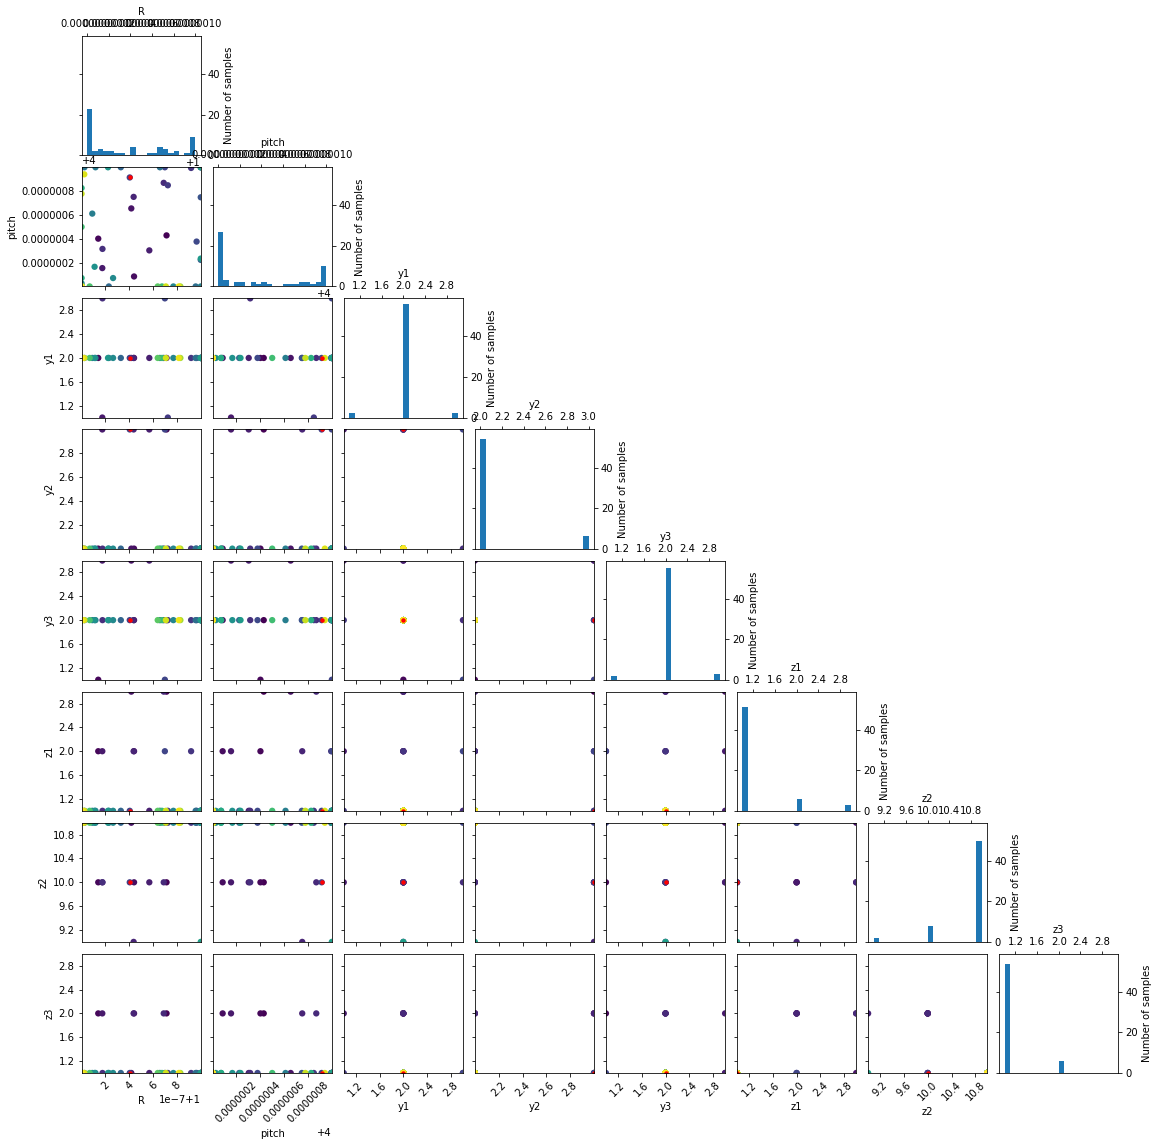

In [28]:
# Visualizing the order in which points where sampled.
# The order in which samples were evaluated is encoded in each point’s color.

plot_evaluations(res, dimensions=["R", "pitch", "y1", "y2", "y3", "z1", "z2", "z3"])
plt.show()

Display the optimal tracking system geometry.

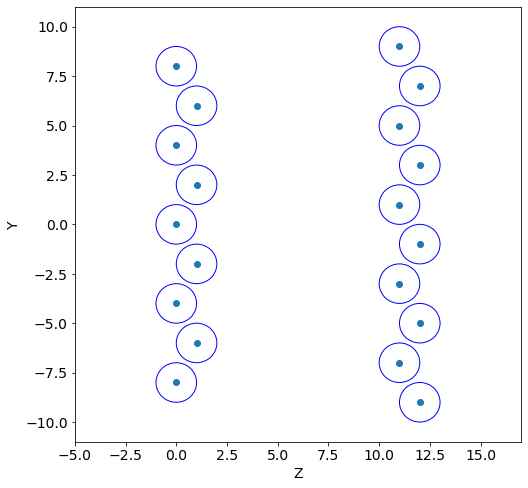

In [29]:
# get found optimal geometry
[R, pitch, y1, y2, y3, z1, z2, z3] = res.x

# Plot the geometry without Tracks
Z, Y = utils.Tracker(R, pitch, y1, y2, y3, z1, z2, z3).create_geometry()
utils.geometry_display(Z, Y, R, y_min=-10, y_max=10)

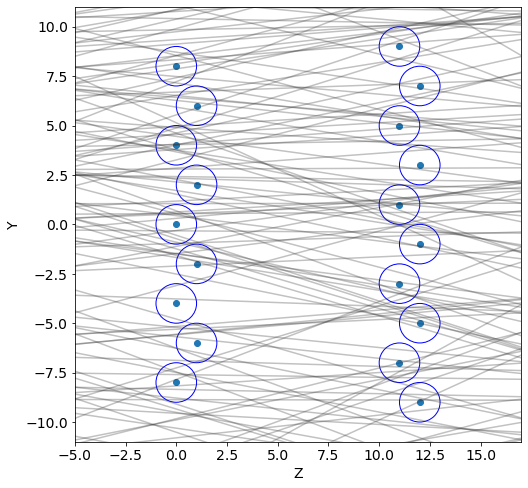

In [30]:
# Plot the geometry with Tracks

utils.geometry_display(Z, Y, R, y_min=-10, y_max=10)
utils.tracks_display(tracks, Z)